In [25]:
! nvidia-smi

Sat May 27 16:27:32 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                        On | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0               26W /  70W|   3219MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the CNN architecture
class CNN(nn.Module):
    def __init__(self, h_size=16):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, h_size, 3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(4),

            nn.Conv2d(h_size, 16, 3),
            nn.LeakyReLU(0.1),
            nn.MaxPool2d(2),

            nn.Flatten(),
            nn.Linear(64, 10),
        )

    def forward(self, x):
        x = self.net(x)
        return x

# Set device
device = 'cuda:1'

In [29]:
batch_size = 64
import math

In [30]:
# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=0)

# Initialize network, loss function and optimizer
net = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)

# Training function
def train(net, dataloader, criterion, optimizer, device):
    net.train()
    running_loss = 0.0
    pbar = tqdm(enumerate(dataloader, 0), total = math.ceil(len(trainset)/batch_size))
    losses = []
    for i, data in pbar:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        pbar.set_description(f'l={loss.item():.5f}')

        losses.append(loss.item())

    return losses

Files already downloaded and verified
Files already downloaded and verified


In [31]:
# Validation function
def validate(net, dataloader, criterion, device):
    net.eval()
    losses = []
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)

            losses.append(loss.item())

    return losses

In [32]:
import lovely_tensors as lt
lt.monkey_patch()

In [33]:
def m11_to_01(t):
    return (t+1.)/2

In [34]:
# m11_to_01(inputs)[:10].rgb

In [35]:
from tqdm.auto import tqdm

In [36]:
try:
    from prettytable import PrettyTable
except:
    ! pip install -q prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [37]:
# Training and validation loop

def train_net(net, num_epochs = 1):
    train_losses = []
    val_losses = []

    net.train()
    net = net.to(device)

    count_parameters(net)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(net.parameters(), lr=0.001)

    for epoch in tqdm ( list ( range(num_epochs) ) ):
        train_losses_e = train(net, trainloader, criterion, optimizer, device)
        val_losses_e = validate(net, testloader, criterion, device)
        train_losses += train_losses_e
        val_losses += val_losses_e
        # print(f"Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Plot loss curves
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Test function
    def test(net, dataloader, device):
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in dataloader:
                images, labels = data
                images, labels = images.to(device), labels.to(device)
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return correct / total

    # Report final accuracy
    accuracy = test(net, testloader, device)
    print(f"Final Test Accuracy: {accuracy * 100:.2f}%")

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |    432     |
|  net.0.bias  |     16     |
| net.3.weight |    2304    |
|  net.3.bias  |     16     |
| net.7.weight |    640     |
|  net.7.bias  |     10     |
+--------------+------------+
Total Trainable Params: 3418


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

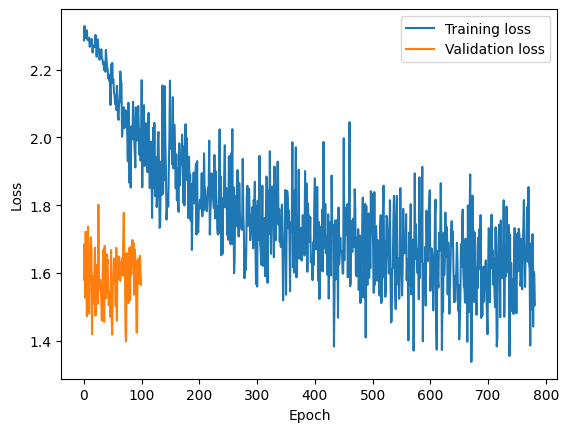

Final Test Accuracy: 43.28%


In [39]:
train_net(CNN(h_size=16))

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |    864     |
|  net.0.bias  |     32     |
| net.3.weight |    4608    |
|  net.3.bias  |     16     |
| net.7.weight |    640     |
|  net.7.bias  |     10     |
+--------------+------------+
Total Trainable Params: 6170


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

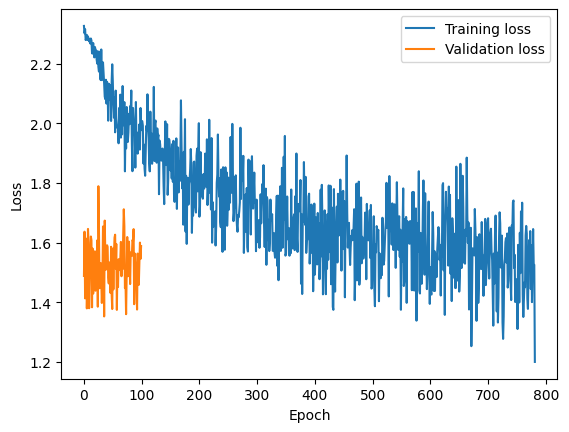

Final Test Accuracy: 44.45%


In [38]:
train_net(CNN(h_size=32))

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |    1728    |
|  net.0.bias  |     64     |
| net.3.weight |    9216    |
|  net.3.bias  |     16     |
| net.7.weight |    640     |
|  net.7.bias  |     10     |
+--------------+------------+
Total Trainable Params: 11674


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

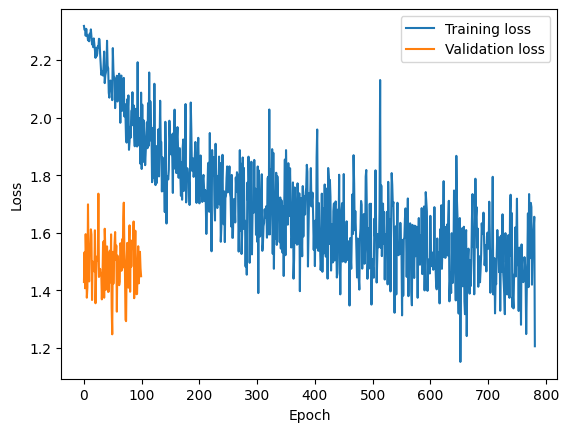

Final Test Accuracy: 46.48%


In [40]:
train_net(CNN(h_size=64))

+--------------+------------+
|   Modules    | Parameters |
+--------------+------------+
| net.0.weight |    3456    |
|  net.0.bias  |    128     |
| net.3.weight |   18432    |
|  net.3.bias  |     16     |
| net.7.weight |    640     |
|  net.7.bias  |     10     |
+--------------+------------+
Total Trainable Params: 22682


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

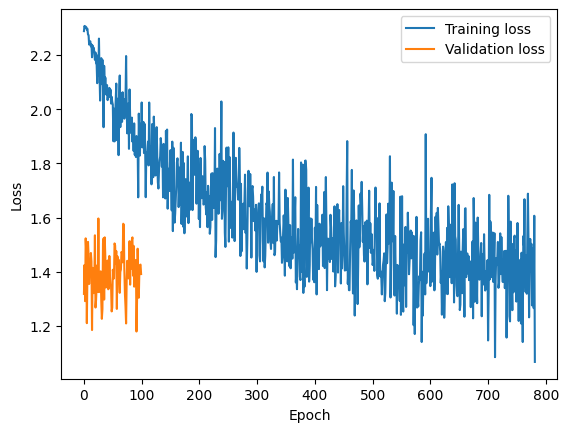

Final Test Accuracy: 50.83%


In [41]:
train_net(CNN(h_size=128))

In [42]:
for batch in trainloader:
    break

In [43]:
x = batch[0]
x

tensor[64, 3, 32, 32] n=196608 x∈[-1.000, 1.000] μ=-0.050 σ=0.507

In [54]:
class CNNSplit(nn.Module):
    def __init__(self, h_size=16):
        super().__init__()

        self.conv1 = nn.Conv2d(3, h_size, 3)
        self.conv2 = nn.Conv2d(h_size//4, 16, 3)
        self.linear = nn.Linear(100, 10)
        self.h_size = h_size

    def forward(self, x):
        p = self.conv1(x)
        pt, ps, pcos, psin = p.chunk(4, dim=1)
        a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()

        a = nn.MaxPool2d(4)(10*a)

        p = self.conv2(a)
        pt, ps, pcos, psin = p.chunk(4, dim=1)
        a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()
        x = nn.Flatten()(10*a)
        
        x = self.linear(x)
        return x

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    432     |
|   conv1.bias  |     16     |
|  conv2.weight |    576     |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 2050


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

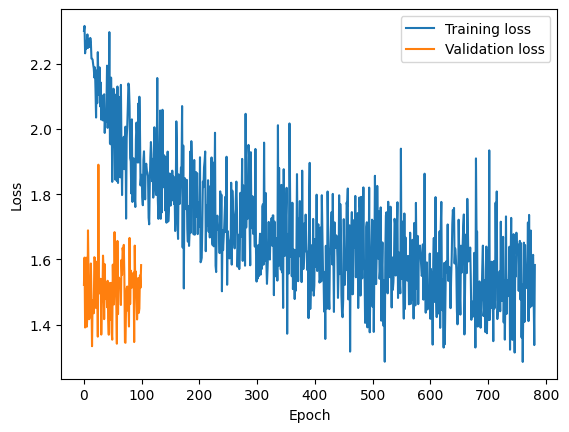

Final Test Accuracy: 44.86%


In [56]:
train_net(CNNSplit(h_size=16))

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    864     |
|   conv1.bias  |     32     |
|  conv2.weight |    1152    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 3074


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

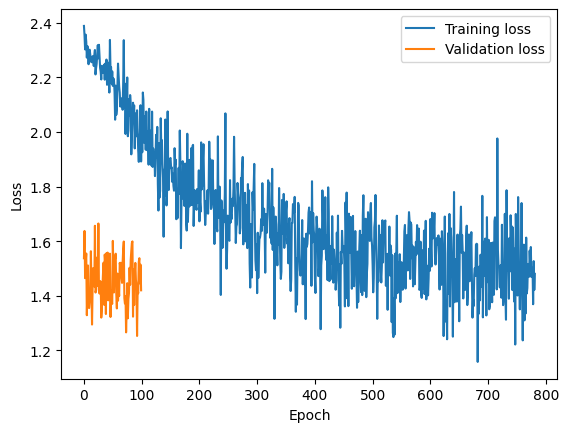

Final Test Accuracy: 47.19%


In [55]:
train_net(CNNSplit(h_size=32))

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    1728    |
|   conv1.bias  |     64     |
|  conv2.weight |    2304    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 5122


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

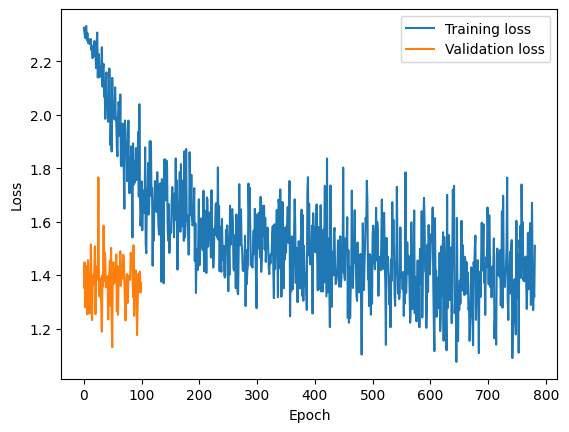

Final Test Accuracy: 49.79%


In [57]:
train_net(CNNSplit(h_size=64))

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    3456    |
|   conv1.bias  |    128     |
|  conv2.weight |    4608    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 9218


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

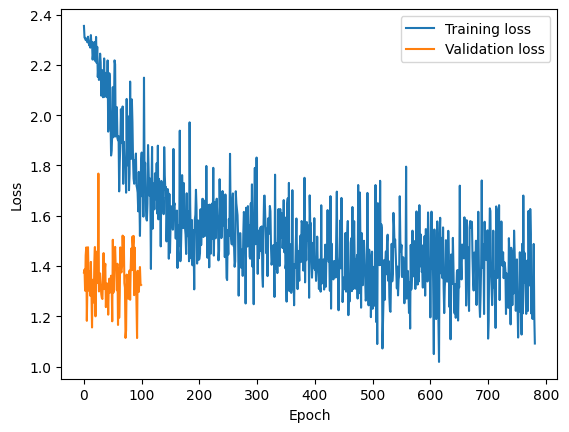

Final Test Accuracy: 51.25%


In [58]:
train_net(CNNSplit(h_size=128))

In [ ]:
break

In [47]:
class CNNSplit2(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 16*2, 3)
        self.conv2 = nn.Conv2d(4*2, 16, 3)
        self.linear = nn.Linear(100, 10)

    def forward(self, x):
        p = self.conv1(x)
        pt, ps, pcos, psin = p.chunk(4, dim=1)
        a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()

        a = nn.AvgPool2d(4)(10*a)

        p = self.conv2(a)
        pt, ps, pcos, psin = p.chunk(4, dim=1)
        a = pt.tanh() * ps.sigmoid() * pcos.cos() * psin.sin()
        x = nn.Flatten()(10*a)
        
        x = self.linear(x)
        return x

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    864     |
|   conv1.bias  |     32     |
|  conv2.weight |    1152    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 3074


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 4)

In [73]:
count_parameters(CNNSplit2())

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    864     |
|   conv1.bias  |     32     |
|  conv2.weight |    1152    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 3074


3074

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  conv1.weight |    864     |
|   conv1.bias  |     32     |
|  conv2.weight |    1152    |
|   conv2.bias  |     16     |
| linear.weight |    1000    |
|  linear.bias  |     10     |
+---------------+------------+
Total Trainable Params: 3074


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

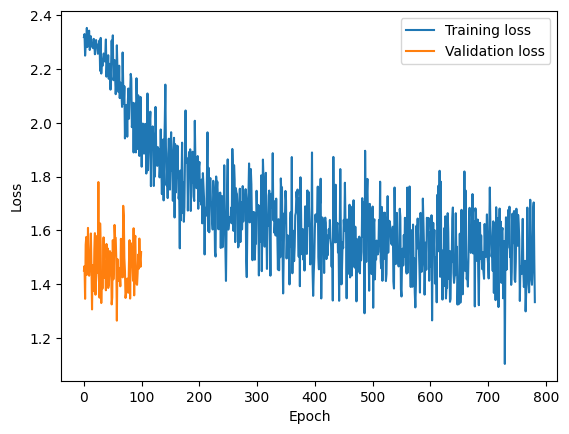

Final Test Accuracy: 46.95%


In [74]:
train_net(CNNSplit2())

In [95]:
class ConvSplitLayer(nn.Module):
    def __init__(self, in_c, out_c, multiplier=10., ks=3, padding=1):
        super().__init__()
        self.conv = nn.Conv2d(in_c, out_c*4, ks, padding=padding)
        self.multiplier = multiplier
        
    def forward(self, x):
        p = self.conv(x)
        p = p.chunk(4, dim=1)
        a = p[0].tanh() * p[1].sigmoid() * p[2].sin() * p[3].cos()
        
        return a * self.multiplier

In [98]:
layer = net = nn.Sequential(
            ConvSplitLayer(3, 16),
            ConvSplitLayer(16, 16),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(16),

            ConvSplitLayer(16, 32),
            ConvSplitLayer(32, 32),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),

            # ConvSplitLayer(32, 64),
            # ConvSplitLayer(64, 64),
            # nn.MaxPool2d(2, 2),
            # nn.BatchNorm2d(64),

            nn.Flatten(), )
layer(torch.rand(32, 3, 32, 32))

tensor[32, 2048] n=65536 x∈[-2.661, 8.003] μ=-1.863e-09 σ=1.000 grad ReshapeAliasBackward0

In [106]:
class BigCNNSplitAs(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            ConvSplitLayer(3, 16),
            # ConvSplitLayer(16, 16),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(16),

            ConvSplitLayer(16, 32),
            # ConvSplitLayer(32, 32),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),

            # ConvSplitLayer(32, 64),
            # ConvSplitLayer(64, 64),
            # nn.MaxPool2d(2, 2),
            # nn.BatchNorm2d(64),

            nn.Flatten(), 

            nn.Linear(2048, 512),
            nn.LeakyReLU(),
            # nn.Linear(512, 256),
            # nn.LeakyReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [100]:
count_parameters(BigCNNSplitAs())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
| net.1.conv.weight |    9216    |
|  net.1.conv.bias  |     64     |
|    net.3.weight   |     16     |
|     net.3.bias    |     16     |
| net.4.conv.weight |   18432    |
|  net.4.conv.bias  |    128     |
| net.5.conv.weight |   36864    |
|  net.5.conv.bias  |    128     |
|    net.7.weight   |     32     |
|     net.7.bias    |     32     |
|    net.9.weight   |  1048576   |
|     net.9.bias    |    512     |
|   net.11.weight   |   131072   |
|    net.11.bias    |    256     |
|   net.13.weight   |    2560    |
|    net.13.bias    |     10     |
+-------------------+------------+
Total Trainable Params: 1249706


1249706

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
|    net.2.weight   |     16     |
|     net.2.bias    |     16     |
| net.3.conv.weight |   18432    |
|  net.3.conv.bias  |    128     |
|    net.5.weight   |     32     |
|     net.5.bias    |     32     |
|    net.7.weight   |  1048576   |
|     net.7.bias    |    512     |
|    net.9.weight   |    5120    |
|     net.9.bias    |     10     |
+-------------------+------------+
Total Trainable Params: 1074666


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

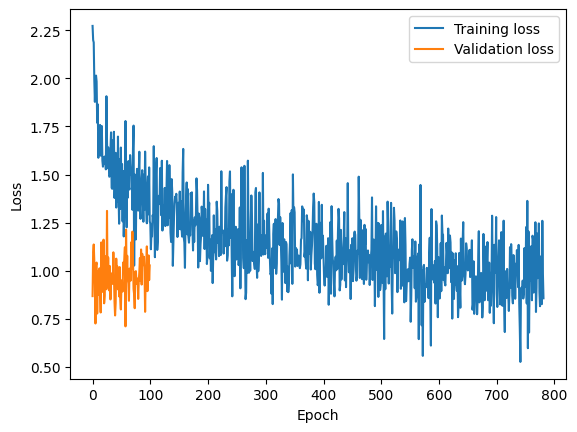

Final Test Accuracy: 65.53%


In [107]:
train_net(BigCNNSplitAs())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
|    net.2.weight   |     16     |
|     net.2.bias    |     16     |
| net.3.conv.weight |   18432    |
|  net.3.conv.bias  |    128     |
|    net.5.weight   |     32     |
|     net.5.bias    |     32     |
|    net.7.weight   |  1048576   |
|     net.7.bias    |    512     |
|    net.9.weight   |   131072   |
|     net.9.bias    |    256     |
|   net.11.weight   |    2560    |
|    net.11.bias    |     10     |
+-------------------+------------+
Total Trainable Params: 1203434


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

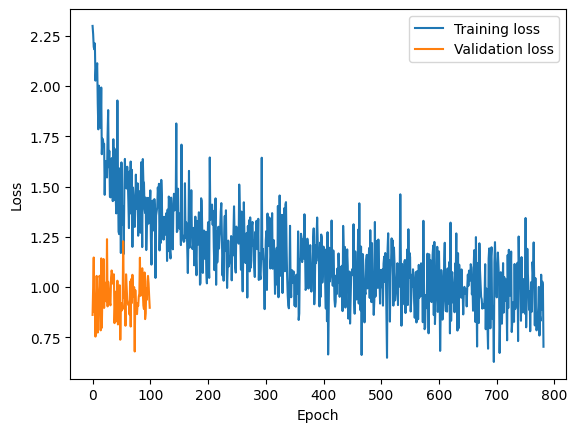

Final Test Accuracy: 66.65%


In [105]:
train_net(BigCNNSplitAs())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
| net.1.conv.weight |    9216    |
|  net.1.conv.bias  |     64     |
|    net.3.weight   |     16     |
|     net.3.bias    |     16     |
| net.4.conv.weight |   18432    |
|  net.4.conv.bias  |    128     |
|    net.6.weight   |     32     |
|     net.6.bias    |     32     |
|    net.8.weight   |  1048576   |
|     net.8.bias    |    512     |
|   net.10.weight   |   131072   |
|    net.10.bias    |    256     |
|   net.12.weight   |    2560    |
|    net.12.bias    |     10     |
+-------------------+------------+
Total Trainable Params: 1212714


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

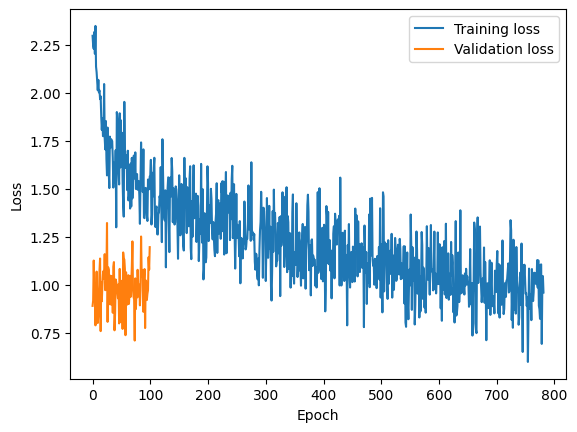

Final Test Accuracy: 64.64%


In [103]:
train_net(BigCNNSplitAs())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
| net.1.conv.weight |    9216    |
|  net.1.conv.bias  |     64     |
|    net.3.weight   |     16     |
|     net.3.bias    |     16     |
| net.4.conv.weight |   18432    |
|  net.4.conv.bias  |    128     |
| net.5.conv.weight |   36864    |
|  net.5.conv.bias  |    128     |
|    net.7.weight   |     32     |
|     net.7.bias    |     32     |
|    net.9.weight   |  1048576   |
|     net.9.bias    |    512     |
|   net.11.weight   |   131072   |
|    net.11.bias    |    256     |
|   net.13.weight   |    2560    |
|    net.13.bias    |     10     |
+-------------------+------------+
Total Trainable Params: 1249706


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

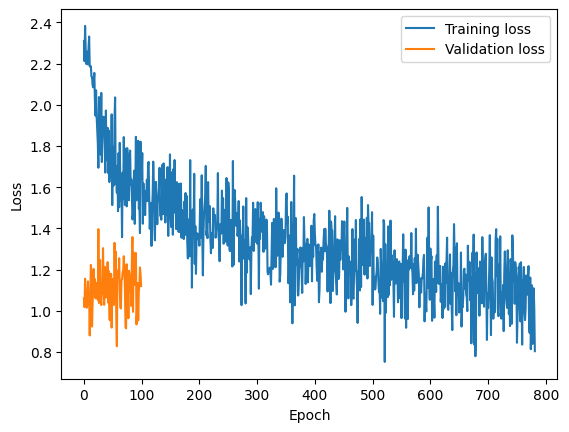

Final Test Accuracy: 61.08%


In [101]:
train_net(BigCNNSplitAs())

+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
| net.0.conv.weight |    1728    |
|  net.0.conv.bias  |     64     |
| net.1.conv.weight |    9216    |
|  net.1.conv.bias  |     64     |
|    net.3.weight   |     16     |
|     net.3.bias    |     16     |
| net.4.conv.weight |   18432    |
|  net.4.conv.bias  |    128     |
| net.5.conv.weight |   36864    |
|  net.5.conv.bias  |    128     |
|    net.7.weight   |     32     |
|     net.7.bias    |     32     |
| net.8.conv.weight |   73728    |
|  net.8.conv.bias  |    256     |
| net.9.conv.weight |   147456   |
|  net.9.conv.bias  |    256     |
|   net.11.weight   |     64     |
|    net.11.bias    |     64     |
|   net.13.weight   |   524288   |
|    net.13.bias    |    512     |
|   net.15.weight   |   131072   |
|    net.15.bias    |    256     |
|   net.17.weight   |    2560    |
|    net.17.bias    |     10     |
+-------------------+------------+
Total Trainable Para

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

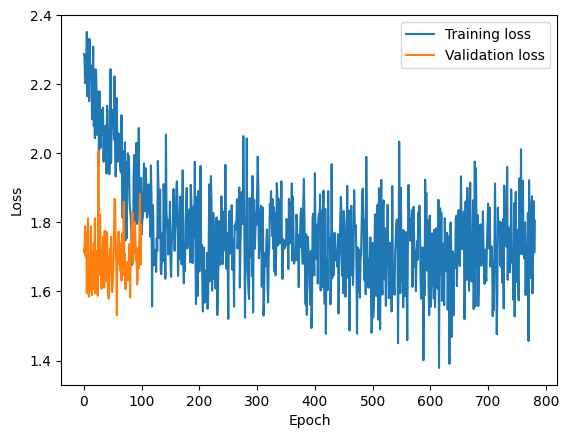

Final Test Accuracy: 36.49%


In [97]:
train_net(BigCNNSplitAs())

In [89]:
net(torch.rand(32, 3, 32, 32))

tensor[32, 1024] n=32768 x∈[-2.719, 7.554] μ=3.027e-09 σ=1.000 grad ReshapeAliasBackward0

In [ ]:
class BigCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

In [76]:
class BigCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(256),

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.LeakyReLU(),
            nn.Linear(1024, 512),
            nn.LeakyReLU(),
            nn.Linear(512, 256),
            nn.LeakyReLU(),
            nn.Linear(256, 10)
        )

    def forward(self, x):
        x = self.net(x)
        return x

+---------------+------------+
|    Modules    | Parameters |
+---------------+------------+
|  net.0.weight |    864     |
|   net.0.bias  |     32     |
|  net.2.weight |   18432    |
|   net.2.bias  |     64     |
|  net.5.weight |     64     |
|   net.5.bias  |     64     |
|  net.6.weight |   73728    |
|   net.6.bias  |    128     |
|  net.8.weight |   147456   |
|   net.8.bias  |    128     |
| net.11.weight |    128     |
|  net.11.bias  |    128     |
| net.12.weight |   294912   |
|  net.12.bias  |    256     |
| net.14.weight |   589824   |
|  net.14.bias  |    256     |
| net.17.weight |    256     |
|  net.17.bias  |    256     |
| net.19.weight |  4194304   |
|  net.19.bias  |    1024    |
| net.21.weight |   524288   |
|  net.21.bias  |    512     |
| net.23.weight |   131072   |
|  net.23.bias  |    256     |
| net.25.weight |    2560    |
|  net.25.bias  |     10     |
+---------------+------------+
Total Trainable Params: 5981002


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/782 [00:00<?, ?it/s]

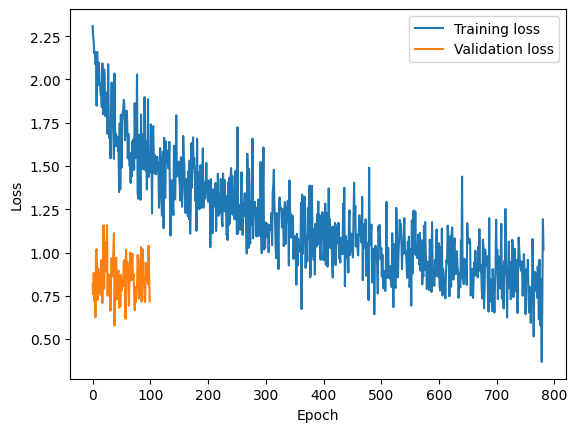

Final Test Accuracy: 70.98%


In [77]:
train_net(BigCNN())